# EDA & Model Building - SpaceShip Titanic Project

Author: James Antony Das

Dataset: Kaggle Competition


##Data Dictionary


* train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
 * PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
 * HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
 * CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
 * Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
 * Destination - The planet the passenger will be debarking to.
 * Age - The age of the passenger.
 * VIP - Whether the passenger has paid for special VIP service during the voyage.
 * RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
 * Name - The first and last names of the passenger.
 * Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
* test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
 * sample_submission.csv - A submission file in the correct format.
 * PassengerId - Id for each passenger in the test set.
 * Transported - The target. For each passenger, predict either True or False.


## Getting Started

Importing required libraries

In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


loading the dataset

In [ ]:
# loading the csv files
data_train = pd.read_csv('/content/drive/MyDrive/Space_ship_titanic/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Space_ship_titanic/test.csv')

In [ ]:
data_train.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [ ]:
data_train.shape, data_test.shape

((8693, 14), (4277, 13))

In [ ]:
data_train.describe().T.style.background_gradient(cmap='Blues', axis=0)

In [ ]:
data_train.describe(include='object').T.style.background_gradient(cmap='Blues', axis=0)

## Exploratory Data Analysis

## Univariate Analysis

**Object features**

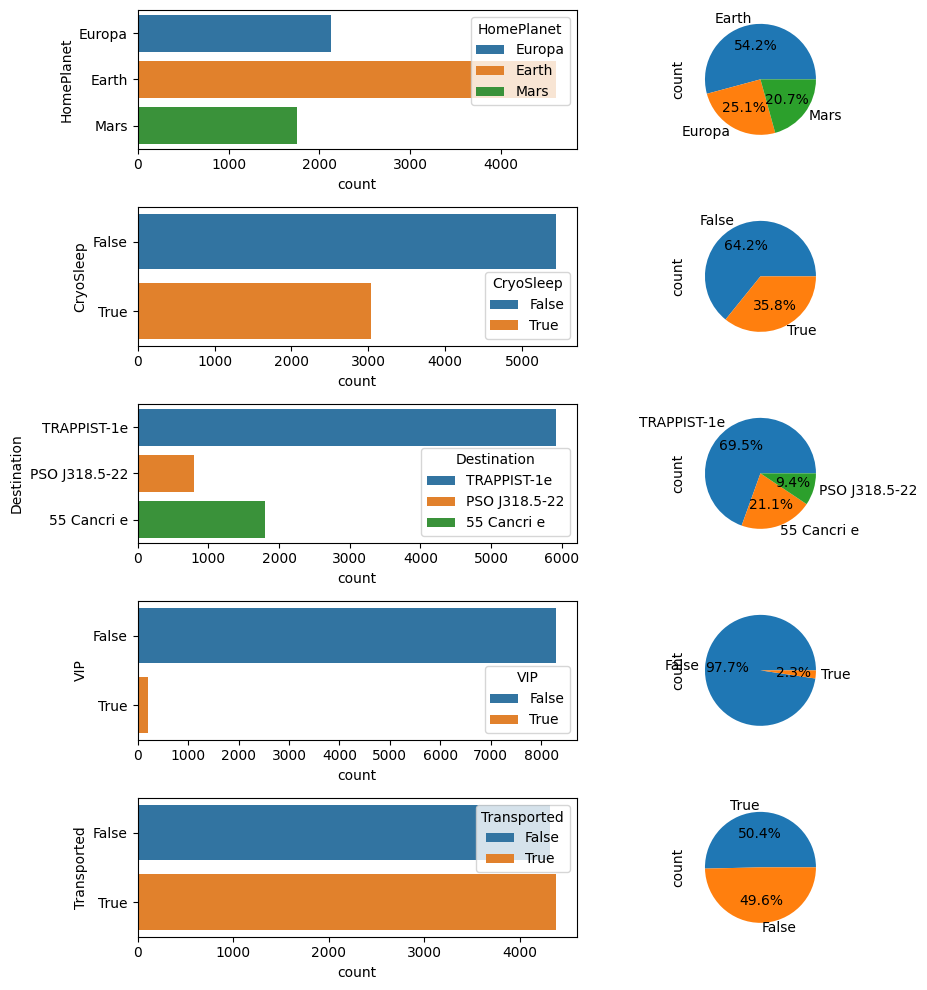

In [ ]:
cols = data_train.drop(['PassengerId', 'Cabin', 'Name'], axis=1).select_dtypes(include=['object']).columns.append(data_train.select_dtypes(include=['bool']).columns)
fig, ax = plt.subplots(len(cols), 2, figsize = (10,10))
for i, col in enumerate(cols):
  sns.countplot(data_train, y = col, ax = ax[i][0], hue = col)
  data_train[col].value_counts().plot(kind = 'pie', autopct = '%1.1f%%', ax = ax[i][1])
plt.tight_layout()

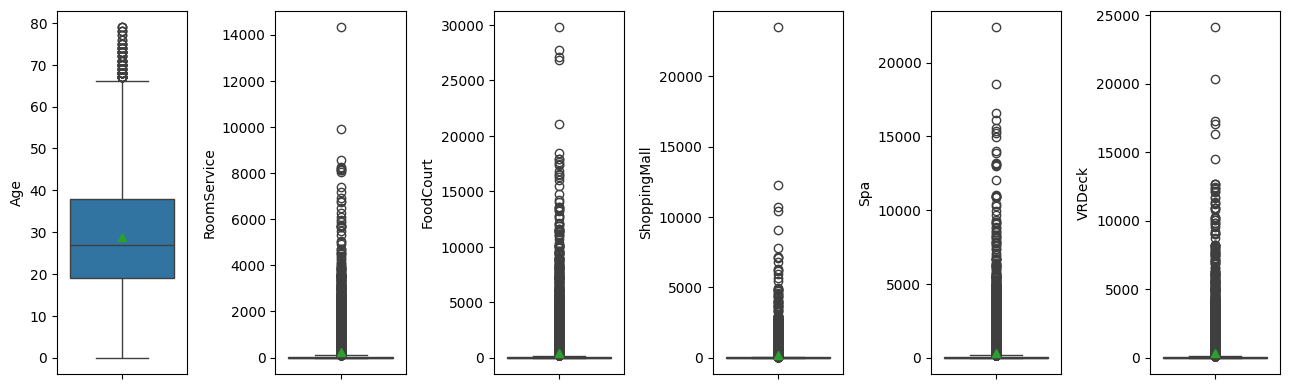

In [ ]:
cols = data_train.select_dtypes(include=['float64', 'int64']).columns
fig, ax = plt.subplots(1, len(cols), figsize = (13,4))
for i, col in enumerate(cols):
  sns.boxplot(data_train, y = col, ax = ax[i], showmeans=True)
plt.tight_layout()

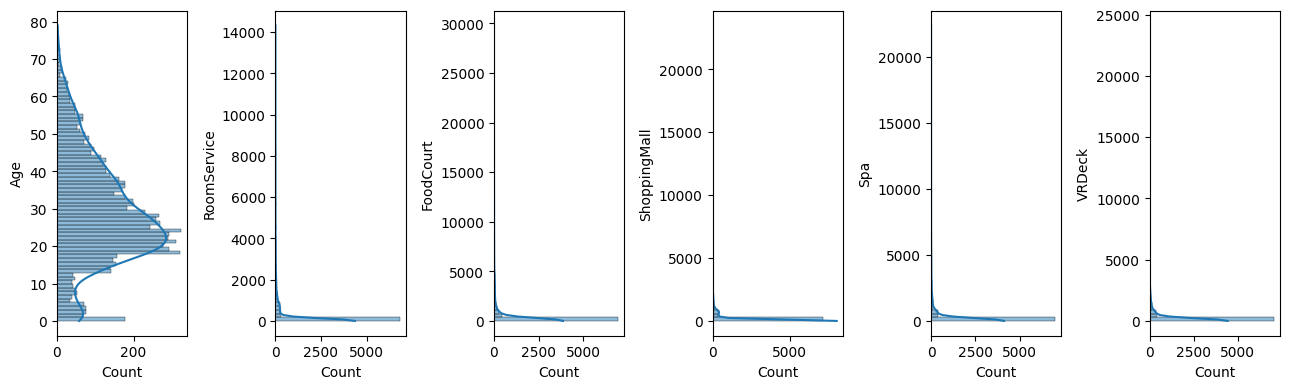

In [ ]:
cols = data_train.select_dtypes(include=['float64', 'int64']).columns
fig, ax = plt.subplots(1, len(cols), figsize = (13,4))
for i, col in enumerate(cols):
  sns.histplot(data_train, y = col, ax = ax[i], bins = 80, kde = True)
plt.tight_layout()

## Bivariate Analysis

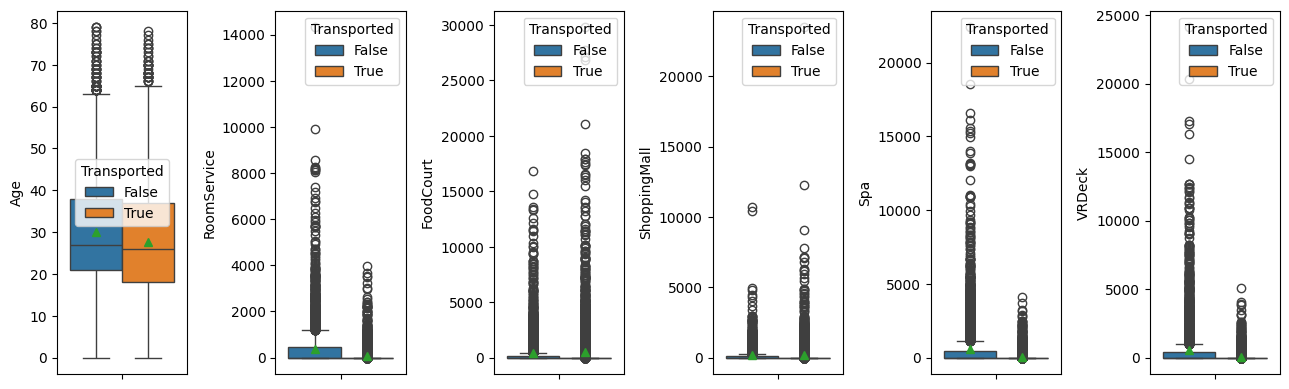

In [ ]:
cols = data_train.select_dtypes(include=['float64', 'int64']).columns
fig, ax = plt.subplots(1, len(cols), figsize = (13,4))
for i, col in enumerate(cols):
  sns.boxplot(data_train, y = col, ax = ax[i], showmeans=True, hue = 'Transported')
plt.tight_layout()

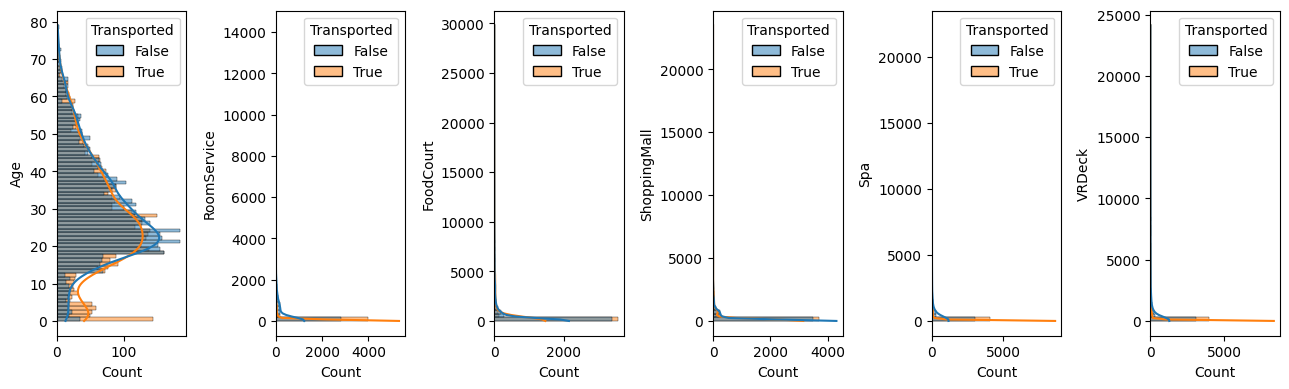

In [ ]:
cols = data_train.select_dtypes(include=['float64', 'int64']).columns
fig, ax = plt.subplots(1, len(cols), figsize = (13,4))
for i, col in enumerate(cols):
  sns.histplot(data_train, y = col, ax = ax[i], bins = 80, kde = True, hue = 'Transported')
plt.tight_layout()

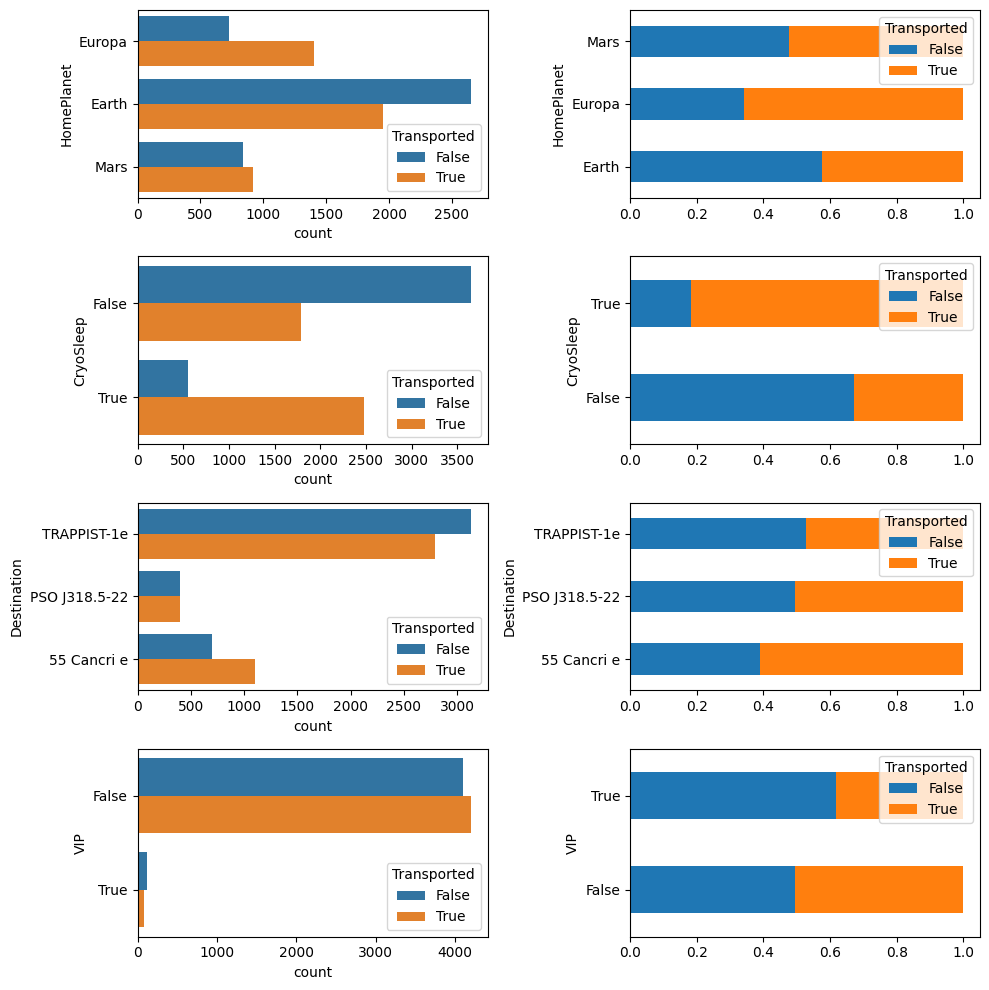

In [ ]:
cols = data_train.drop(['PassengerId', 'Cabin', 'Name'], axis=1).select_dtypes(include=['object']).columns
fig, ax = plt.subplots(len(cols), 2, figsize = (10,10))
for i, col in enumerate(cols):
  sns.countplot(data_train, y = col, ax = ax[i][0], hue = 'Transported')
  data_train.groupby(col)['Transported'].value_counts(normalize = True).unstack().plot(kind = 'barh', stacked = True, ax = ax[i][1])
plt.tight_layout()

In [ ]:
data_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

## ML Pipeline

**Data Preprocessing**

In [ ]:
def data_splitter(df):
  df[['deck', 'num', 'side']] = df.Cabin.str.split('/', expand=True)
  df[['first_name', 'last_name']] = df.Name.str.split(' ', expand=True)
  df[['group', 'group_num']] = df.PassengerId.str.split('_', expand=True)
  df['money_spent'] = df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck
  df['money_spent2'] = df.money_spent > 0
  df['money_spent2'] = df.money_spent.replace({True:1, False:0})
  return df

In [ ]:
def dtype_control(df):
  df = df.astype({'group':int, 'group_num':int, 'num': float})
  return df

**Data Encoding**

In [ ]:
def binary_encoding(df):
  df.CryoSleep = df.CryoSleep.replace({True:1, False:0})
  df.VIP = df.VIP.replace({True:1, False:0})
  return df

In [ ]:
def label_encoding(df):
  df.HomePlanet = df.HomePlanet.replace({'Earth':0, 'Europa':1, 'Mars':2})
  df.Destination = df.Destination.replace({'TRAPPIST-1e':0, '55 Cancri e':1, 'PSO J318.5-22':2})
  df.deck = df.deck.replace({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T': 7})
  df.side = df.side.replace({'P':0, 'S':1})
  return df

In [ ]:
def onehot_encoding(df):
  df = pd.get_dummies(df, columns=['HomePlanet', 'Destination', 'deck', 'side'], drop_first=True, dtype=int)
  return df

**Dropping unused columns**

In [ ]:
def drop_columns(df):
  df.drop(['PassengerId', 'Cabin', 'Name'], axis=1, inplace=True)
  df.drop(['first_name', 'last_name', 'group_num'], axis=1, inplace=True)
  return df

**Pipeline**

In [ ]:
# importing the necessary classes
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

In [ ]:
preprocessing = Pipeline(steps=[('data_splitter', FunctionTransformer(data_splitter, feature_names_out='one-to-one')),
                                ('dtype_control', FunctionTransformer(dtype_control, feature_names_out='one-to-one')),
                                ('binary encoding', FunctionTransformer(binary_encoding, feature_names_out='one-to-one')),
                                ('label encoding', FunctionTransformer(label_encoding, feature_names_out='one-to-one')),
                                ('onehot encoding', FunctionTransformer(onehot_encoding, feature_names_out='one-to-one')),
                                ('drop columns', FunctionTransformer(drop_columns, feature_names_out='one-to-one'))])
preprocessing

Pipeline(steps=[('data_splitter',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<function data_splitter at 0x7f8544925c60>)),
                ('dtype_control',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<function dtype_control at 0x7f85056d4ca0>)),
                ('binary encoding',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<function binary_encoding at 0x7f...)),
                ('label encoding',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<function label_encoding at 0x7f85056d4dc0>)),
                ('onehot encoding',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<function onehot_encoding at 0x7f85056d4ee0>)),
                ('drop columns',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<function drop_columns at 0x7f85056d4f70>))])

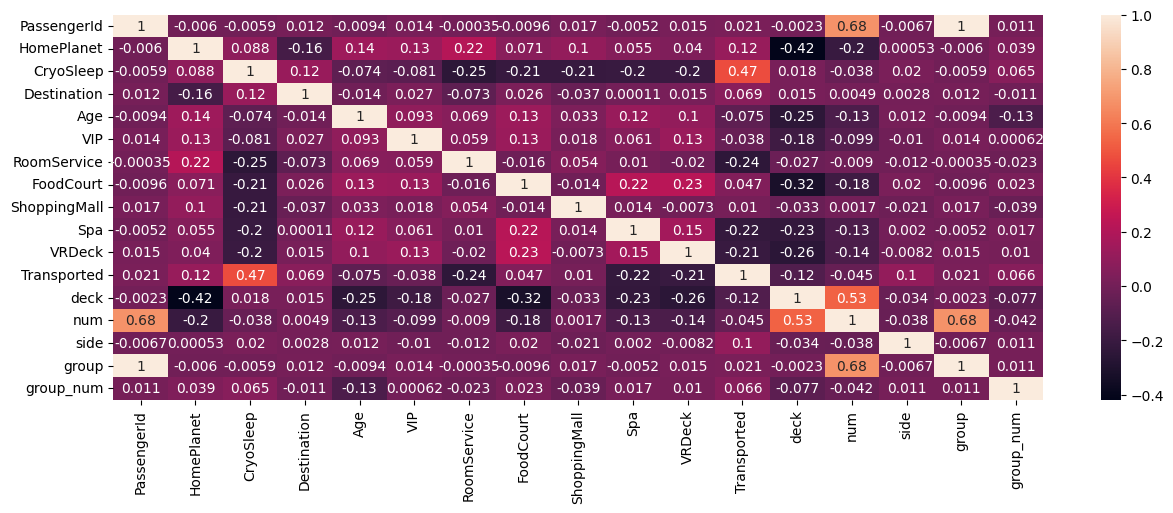

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,5))
sns.heatmap(data_train.pipe(data_splitter)
                      .pipe(dtype_control)
                      .pipe(binary_encoding)
                      .pipe(label_encoding)
                      .drop(['Name', 'Cabin', 'first_name', 'last_name'],
            axis=1).corr(), annot=True, ax = ax)
plt.show()

## More EDA & Missing value Imputation

In [ ]:
data = data_train.copy()
data = data.pipe(data_splitter).pipe(dtype_control).pipe(binary_encoding)
data.drop(['PassengerId', 'Cabin', 'Name'], axis=1, inplace=True)
data.head()

HomePlanet  CryoSleep  Destination   Age  VIP  RoomService  FoodCourt  \
0     Europa        0.0  TRAPPIST-1e  39.0  0.0          0.0        0.0   
1      Earth        0.0  TRAPPIST-1e  24.0  0.0        109.0        9.0   
2     Europa        0.0  TRAPPIST-1e  58.0  1.0         43.0     3576.0   
3     Europa        0.0  TRAPPIST-1e  33.0  0.0          0.0     1283.0   
4      Earth        0.0  TRAPPIST-1e  16.0  0.0        303.0       70.0   

   ShoppingMall     Spa  VRDeck  Transported deck  num side first_name  \
0           0.0     0.0     0.0        False    B  0.0    P      Maham   
1          25.0   549.0    44.0         True    F  0.0    S     Juanna   
2           0.0  6715.0    49.0        False    A  0.0    S     Altark   
3         371.0  3329.0   193.0        False    A  0.0    S      Solam   
4         151.0   565.0     2.0         True    F  1.0    S      Willy   

     last_name  group  group_num  money_spent  money_spent2  
0    Ofracculy      1          1          0.0           0.0  
1        Vines      2          1        736.0         736.0  
2       Susent      3          1      10383.0       10383.0  
3       Susent      3          2       5176.0        5176.0  
4  Santantines      4          1       1091.0        1091.0

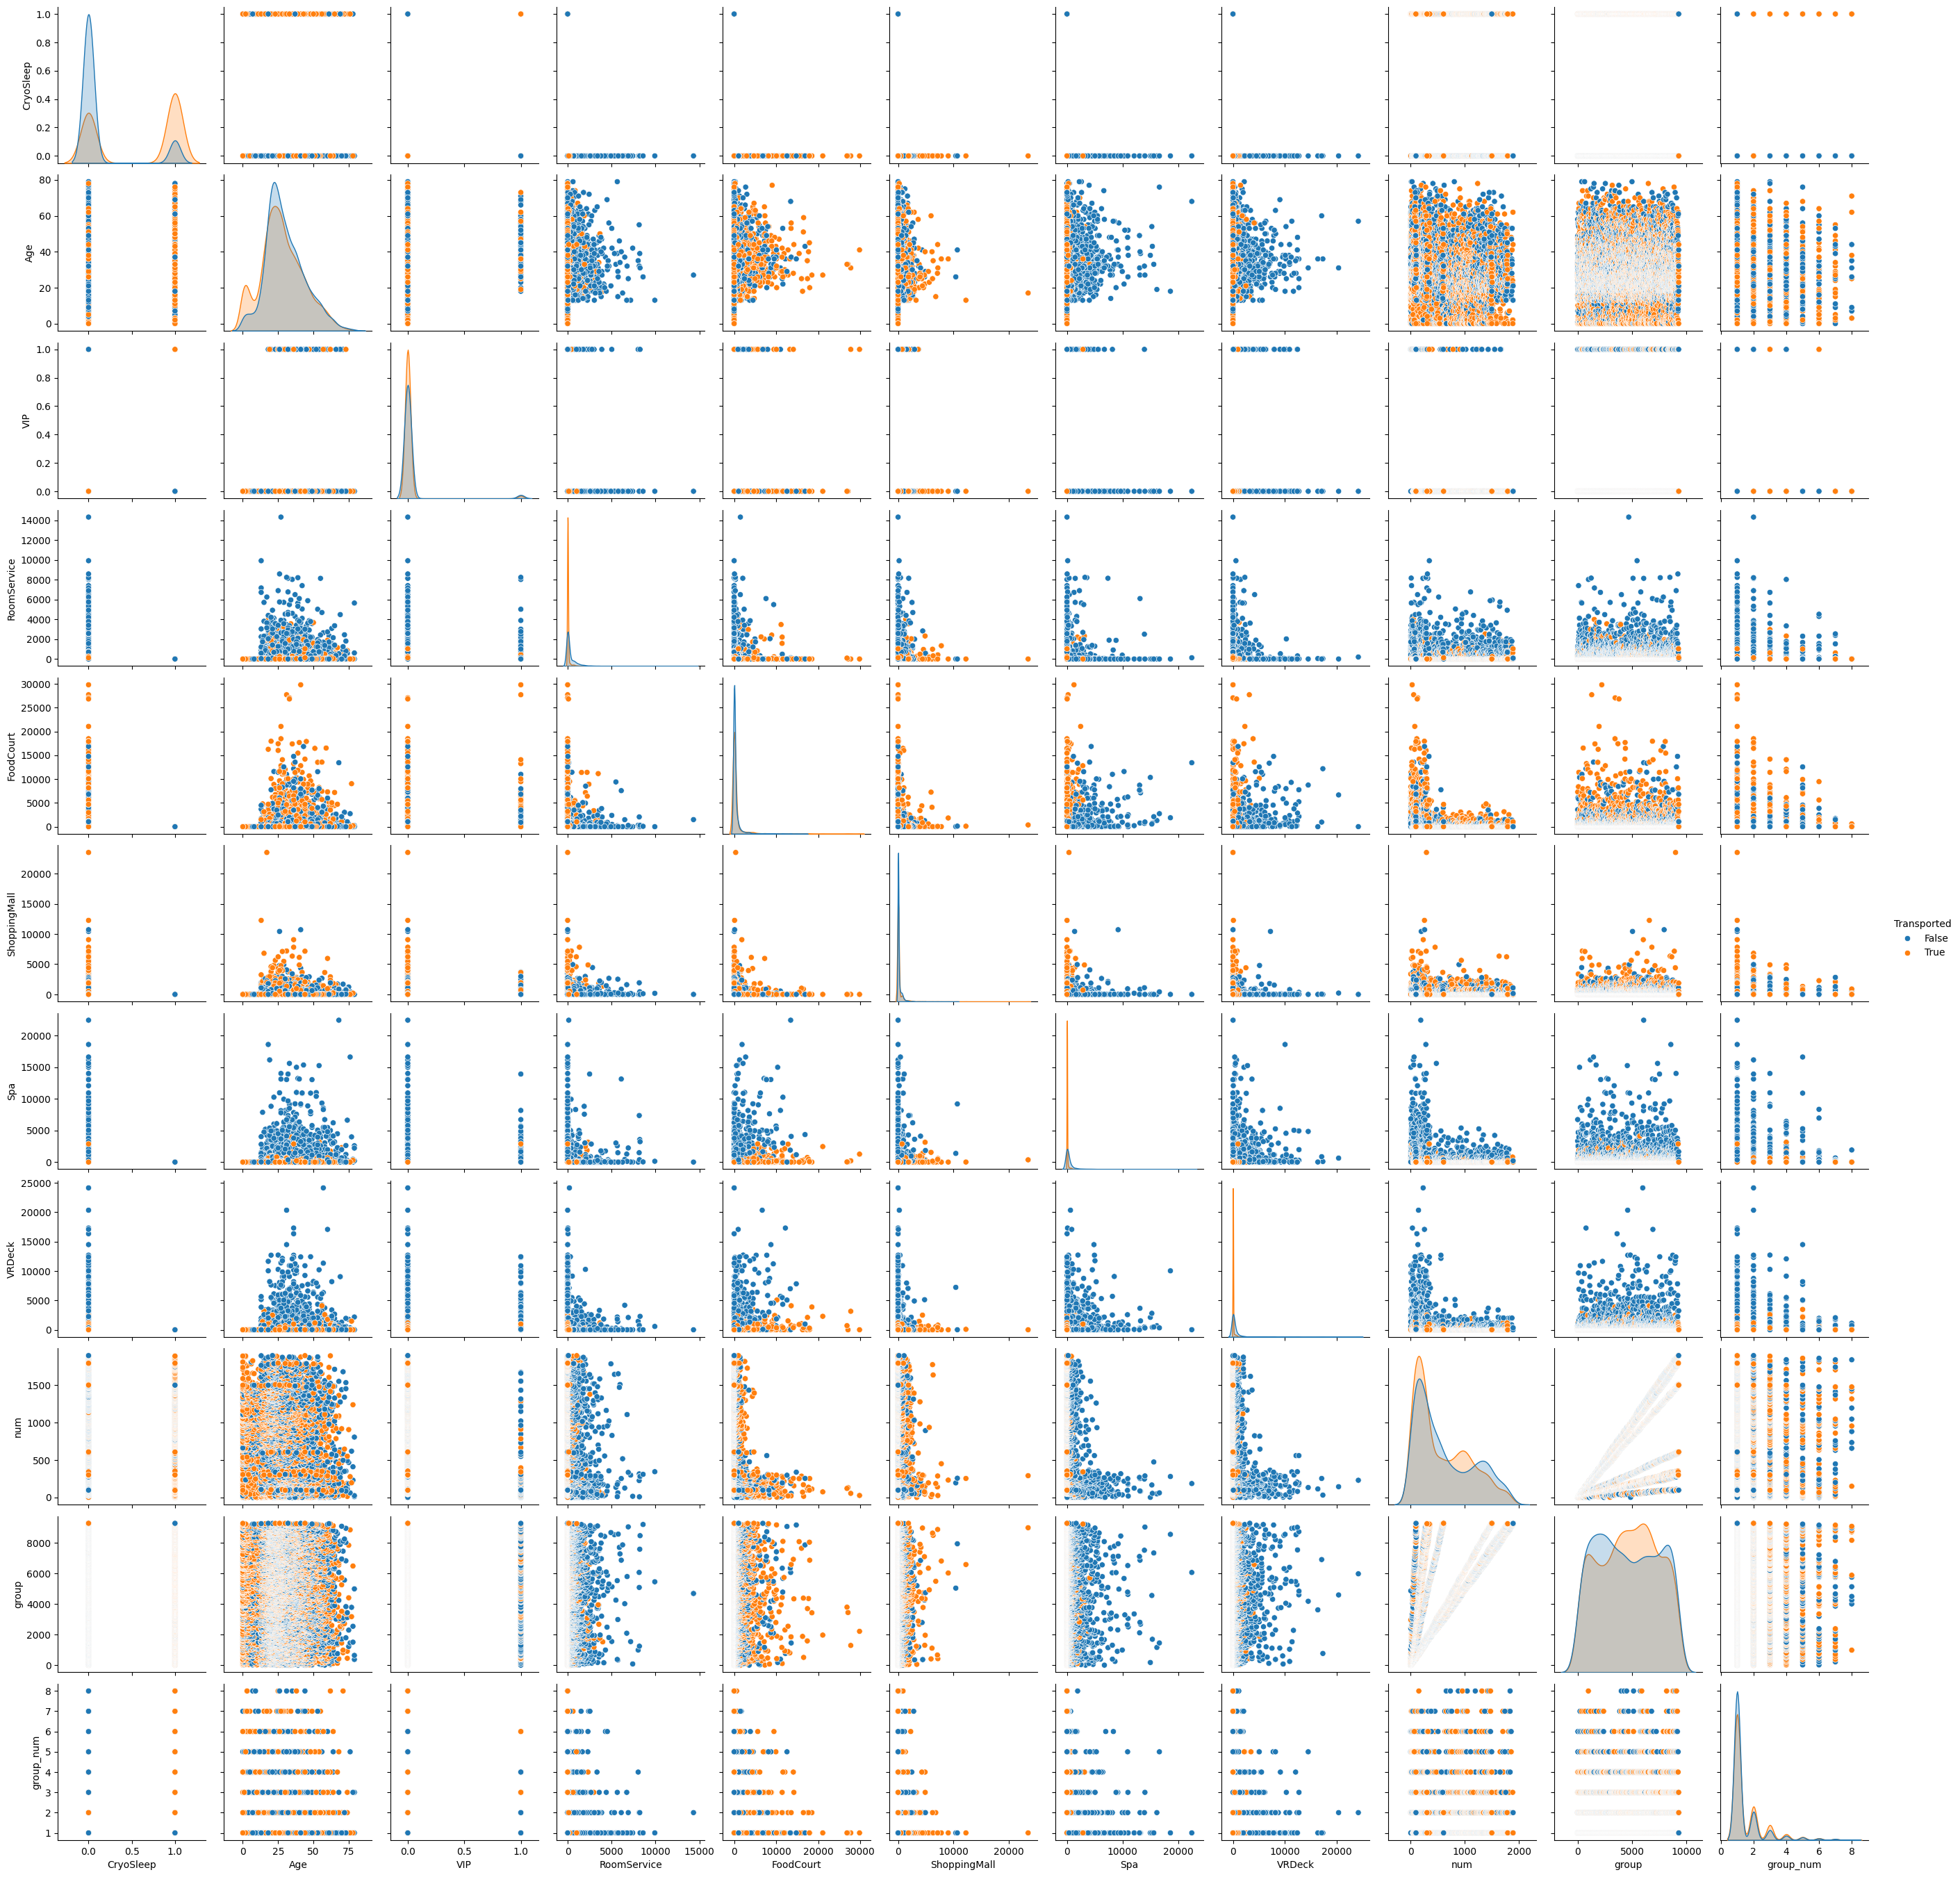

In [ ]:
sns.pairplot(data, hue = 'Transported');

There's an interesting pattern with group and num

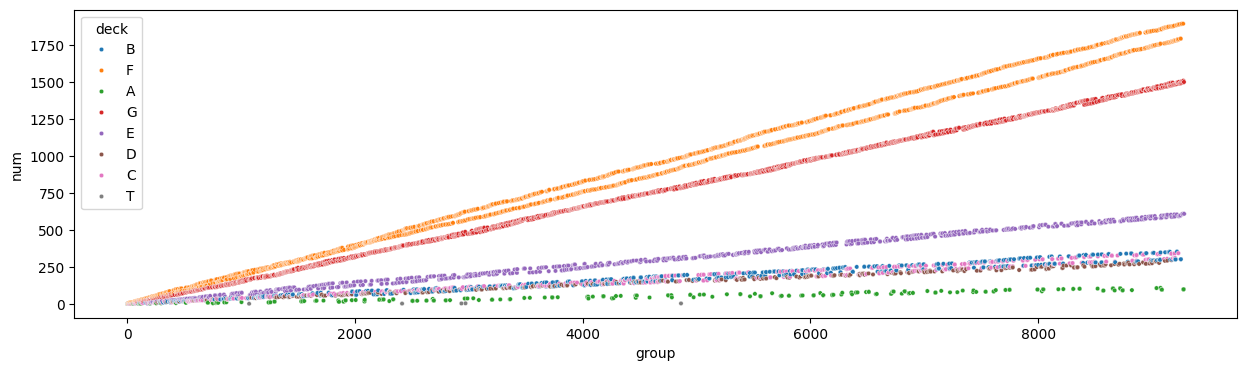

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,4))
sns.scatterplot(data, x = 'group', y = 'num', ax = ax, hue = 'deck', s = 10)
plt.show()

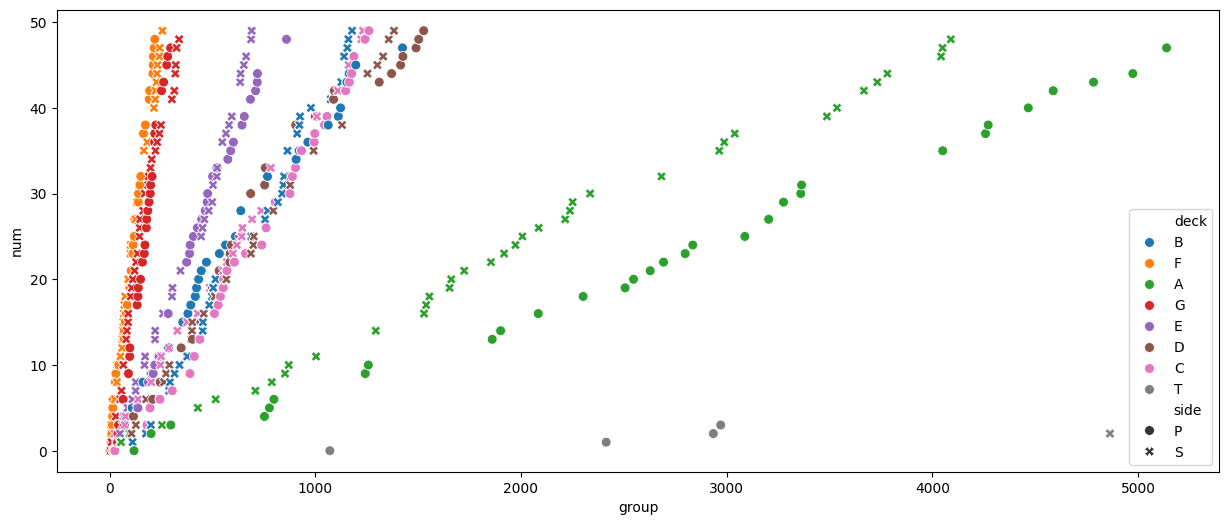

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,6))
sns.scatterplot(data[data['num']<50], x = 'group', y = 'num', ax = ax, hue = 'deck', s = 50, style = 'side')
plt.show()

In [ ]:
dt = data[data.deck.isnull()].drop(['first_name', 'last_name'], axis=1).head()
dt.style.highlight_null('pink')

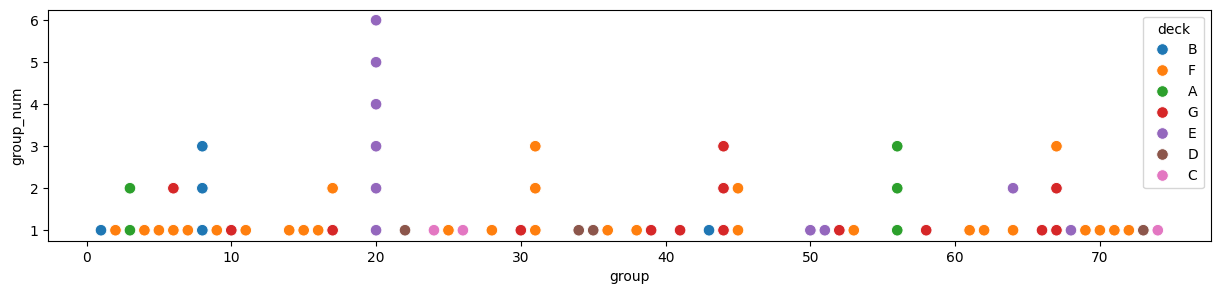

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,3))
sns.scatterplot(data[data['group']<75], x = 'group', y = 'group_num', ax = ax, hue = 'deck', s = 70)
plt.show()

**Insight**
* people from the same group were from the same deck

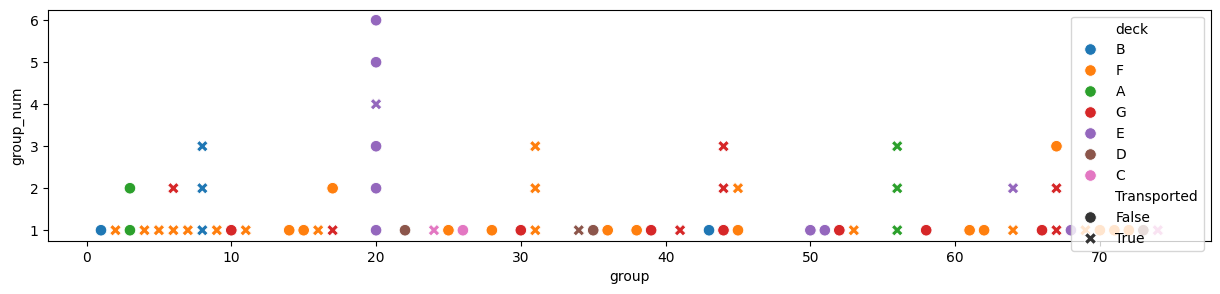

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,3))
sns.scatterplot(data[data['group']<75], x = 'group', y = 'group_num', ax = ax, hue = 'deck', s = 70, style = 'Transported')
plt.show()

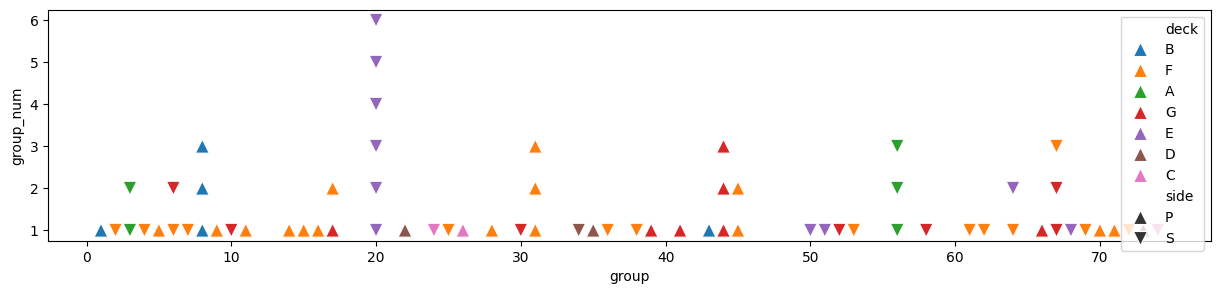

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,3))
sns.scatterplot(data[data['group']<75], x = 'group', y = 'group_num', ax = ax, hue = 'deck', s = 100, style = 'side', markers = ['^', 'v'])
plt.show()

**Insight**
* People in same group are in the same side

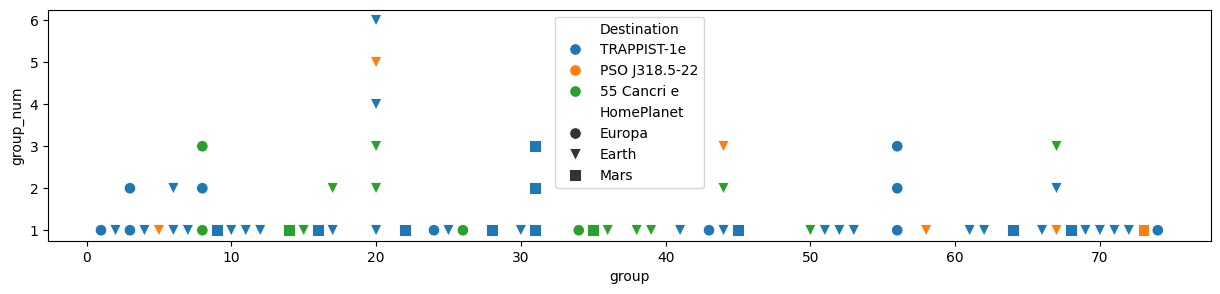

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,3))
sns.scatterplot(data[data['group']<75], x = 'group', y = 'group_num', ax = ax, hue = 'Destination', s = 70, style = 'HomePlanet', markers = ['o', 'v', 's'])
plt.show()

**Insight**
* People from same group are from same home planet

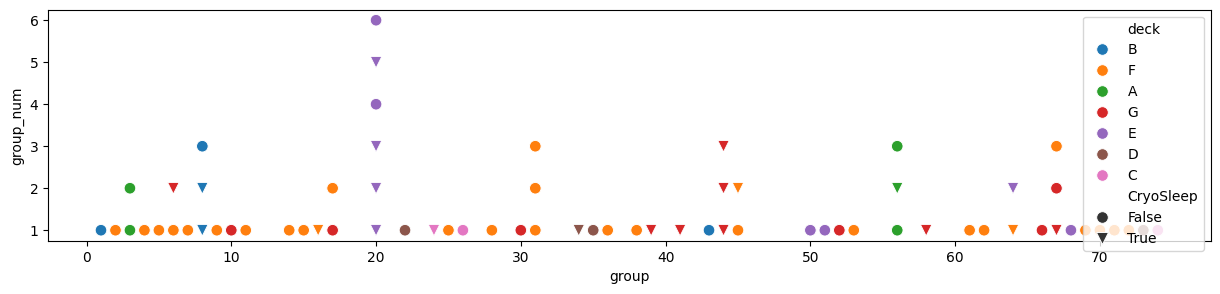

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,3))
sns.scatterplot(data[data['group']<75], x = 'group', y = 'group_num', ax = ax, hue = 'deck', s = 70, style = 'CryoSleep', markers = ['o', 'v'])
plt.show()

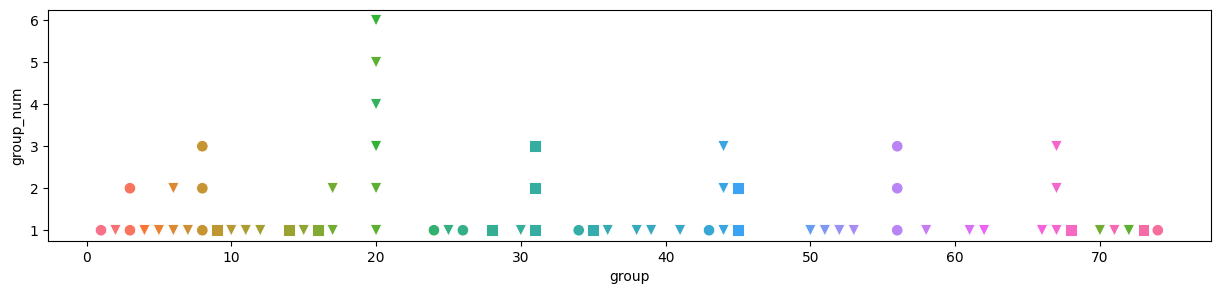

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,3))
sns.scatterplot(data[data['group']<75], x = 'group', y = 'group_num', ax = ax, hue = 'last_name', s = 70, style = 'HomePlanet', markers = ['o', 'v', 's'], legend=False)
plt.show()

**Insight**
* People with same name are in same group

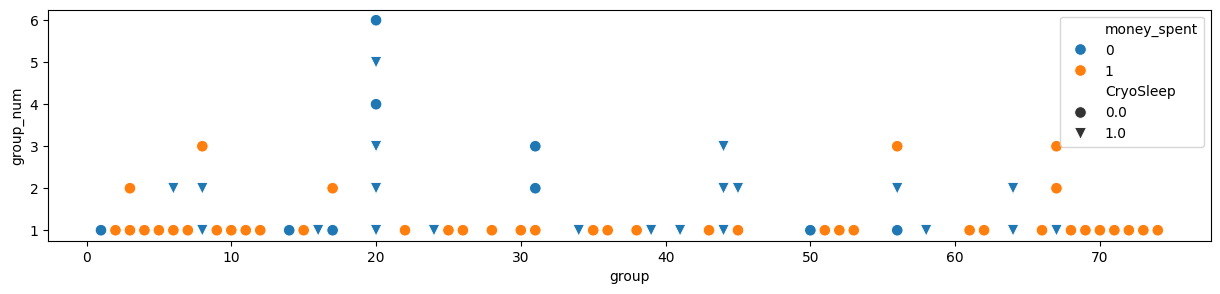

In [ ]:
data['total_spend'] = data.RoomService + data.FoodCourt + data.ShoppingMall + data.Spa + data.VRDeck
data['money_spent'] = data.total_spend > 0
data['money_spent'] = data.money_spent.replace({True:1, False:0})

fig, ax = plt.subplots(1, 1, figsize = (15,3))
sns.scatterplot(data[data['group']<75], x = 'group', y = 'group_num', ax = ax, hue = 'money_spent', s = 70, style = 'CryoSleep', markers = ['o', 'v'])
plt.show()

data.drop(['total_spend','money_spent'], axis=1, inplace=True)

**Insight**
* People who are in cryoSleep didn't spend the money

But, this linear relationship is practically useless,

Since, the column, 'num' and 'deck' are usually missing together, leaving us with 1 Dimensional data.

So, we can't utlitlize this in any meaningful way.

This is too complex to process manually..

Let's utilize the Experimental, Iterative Imputer


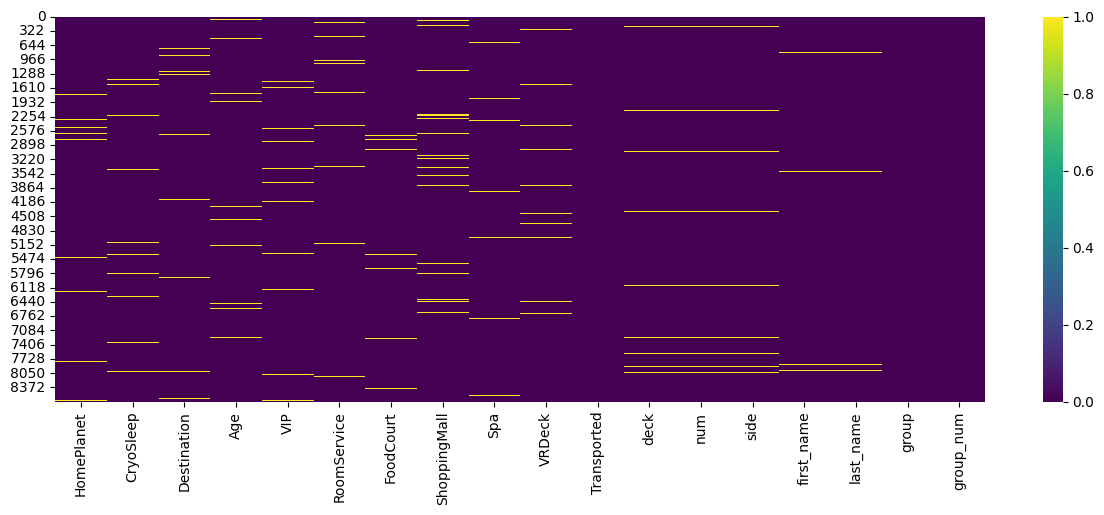

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,5))
sns.heatmap(data.isnull(), annot=False, ax = ax, cmap = 'viridis');

## Iterative Imputer

In [ ]:
data[data.isnull().any(axis = 1)].sample(10).style.highlight_null('pink')

In [ ]:
Xdata = pd.concat([data_train.drop('Transported', axis=1), data_test], axis=0)
Xtdata = preprocessing.fit_transform(Xdata)

Xm = Xtdata.copy()
Xtdata.dropna(inplace=True)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=100, random_state=0)
imp.fit(Xtdata)

IterativeImputer(max_iter=100, random_state=0)

Let's check missing values

In [ ]:
# checking missing values
xdata = imp.transform(Xtdata)
xdata = pd.DataFrame(xdata, columns=Xtdata.columns)
xdata.isnull().sum()

CryoSleep          0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
num                0
group              0
money_spent        0
money_spent2       0
HomePlanet_1.0     0
HomePlanet_2.0     0
Destination_1.0    0
Destination_2.0    0
deck_1.0           0
deck_2.0           0
deck_3.0           0
deck_4.0           0
deck_5.0           0
deck_6.0           0
deck_7.0           0
side_1.0           0
dtype: int64

In [ ]:
xdata.describe().T.style.background_gradient(cmap='Blues', axis=1)

great! we don't have any missing values!

Let's move on to the model building.

## Model Building

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluating model - Traing Vs Test dataset
def model_eval(model, X_train, y_train, X_test, y_test, average = 'binary'):

  """ A function for evaluating model against Training and Testing scores """

  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  df_type = ['Train', 'Test']

  col_acc = [accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)]
  col_pre = [precision_score(y_train, y_pred_train, average = average), precision_score(y_test, y_pred_test, average = average)]
  col_rec = [recall_score(y_train, y_pred_train, average = average), recall_score(y_test, y_pred_test, average = average)]
  col_f1s = [f1_score(y_train, y_pred_train, average = average), f1_score(y_test, y_pred_test, average = average)]

  per_dict = {'Accuracy' : col_acc, 'Precision': col_pre, 'Recall': col_rec, 'F-score': col_f1s}
  per_df = pd.DataFrame(per_dict, index = df_type)

  return per_df


## Model Selection

In [ ]:
train = preprocessing.fit_transform(data_train)
train.dropna(inplace=True)
X = train.drop('Transported', axis=1)
y = train.Transported.replace({True:1, False:0})

In [ ]:
# importing the library
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

### Decision Tree classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# decision tree classifier
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [ ]:
model_eval(dt, X_train, y_train, X_test, y_test)

Accuracy  Precision    Recall   F-score
Train  0.999798   1.000000  0.999598  0.999799
Test   0.745061   0.742173  0.754682  0.748375

**Insight**
* The model is overfitted.

### Bagging Classifier

In [ ]:
# bagging classifier
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier(random_state=1)
bc.fit(X_train, y_train)

BaggingClassifier(random_state=1)

In [ ]:
model_eval(bc, X_train, y_train, X_test, y_test)

Accuracy  Precision    Recall   F-score
Train  0.985881   0.995494  0.976296  0.985801
Test   0.783631   0.807692  0.747191  0.776265

**Insight**
* The model seems overfitted as well.

### Random forest Classifier

In [ ]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [ ]:
model_eval(rf, X_train, y_train, X_test, y_test)

Accuracy  Precision    Recall   F-score
Train  0.999798   0.999598  1.000000  0.999799
Test   0.788335   0.805336  0.763109  0.783654

**Insight**
* The model is overfitted on the training dataset

### XGboost Classifier

In [ ]:
# xgboost classifier
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=1)
xg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [ ]:
model_eval(xg, X_train, y_train, X_test, y_test)

Accuracy  Precision    Recall   F-score
Train  0.960468   0.954059  0.967859  0.960909
Test   0.799153   0.800939  0.798689  0.799812

**Insight**
* The model seems not overfitted, but the accuracy score could be better.

### CatBoost Classifier

In [ ]:
!pip install catboost

In [ ]:
# catboost
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(random_state=1, verbose=0)
cbc.fit(X_train, y_train)

In [ ]:
model_eval(cbc, X_train, y_train, X_test, y_test)

Accuracy  Precision    Recall   F-score
Train  0.891892   0.883694  0.903576  0.893524
Test   0.809031   0.796595  0.832397  0.814103

**Insight**
* The model is not overfitted
* The model seems balanced.

## Final model

Let's select CatBoost as the final model.

## HyperParameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

In [ ]:
cb_tuned = GridSearchCV(estimator = CatBoostClassifier(random_state=1, verbose=0),
                        param_grid = {'max_depth': [3,4,5],
                                      'n_estimators':[100, 200, 300]},
                        scoring ='accuracy',
                        cv = 5)
cb_tuned.fit(X, y)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7d745ea28e20>,
             param_grid={'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [ ]:
cb_tuned.best_params_

{'max_depth': 4, 'n_estimators': 100}

In [ ]:
# save the model
import pickle
pickle.dump(cb_tuned, open('model.pkl', 'wb'))

### Building the Final model

In [ ]:
Xdata = pd.concat([data_train.drop('Transported', axis=1), data_test], axis=0)
Xtdata = preprocessing.fit_transform(Xdata)

Xm = Xtdata.copy()
Xtdata.dropna(inplace=True)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=100, random_state=0)
imp.fit(Xtdata)

IterativeImputer(max_iter=100, random_state=0)

In [ ]:
Xt = Xm[8693:]
Xt1 = imp.transform(Xt)
xydata = pd.DataFrame(Xt1, columns=Xm.columns)

final_submission = pd.DataFrame()
final_submission['PassengerId'] = data_test.PassengerId
final_submission['Transported'] = cb_tuned.predict(xydata)
final_submission['Transported'].replace({1:True, 0:False}, inplace=True)
final_submission.to_csv('submission.csv', index=False)
final_submission.head()

PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True

This is the final submission for the dataset.